# SIT720 Assignment 3
Bryon Baker

Student number: 85031775

In [1]:
!pip3 install numpy
!pip3 install pandas
!pip3 install scikit-learn

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import warnings
import random
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 

# Configure ssl for unverified content so we can load a dataset from an unknown source (github).
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Question 1

Load and explore the training dataset. Explain the steps that you have taken.

In [3]:
import os

train_url = 'https://raw.githubusercontent.com/bryonbaker/datasets/main/SIT720/Ass3/ac_train_data.csv'
test_url = 'https://raw.githubusercontent.com/bryonbaker/datasets/main/SIT720/Ass3/ac_test_data.csv'
train_path = '/opt/app-root/src/datasets/SIT720/Ass3/ac_train_data.csv'
test_path = '/opt/app-root/src/datasets/SIT720/Ass3/ac_test_data.csv'

#
# Work out if the datasets are local. If not use a remote url. Preference is local.
#
print("Load datasets from local or remote resource:")
print("="*50)
if os.path.isfile(train_path):
    print("Training data is local")
    training_data = train_path
else:
    print("Training data is remote. Downloading file from: {}".format(train_url))
    training_data = train_url

if os.path.isfile(test_path):
    print("Test data is local")
    test_data = test_path
else:
    print("Test data is remote. Downloading file from: {}".format(test_url))
    test_data = test_url
print()

# Load the datasets from either local or remote.
train_df = pd.read_csv(training_data)
test_df = pd.read_csv(test_data)

Load datasets from local or remote resource:
Training data is local
Test data is local



In [4]:
# Ordinal encode the days of week.

oldCol = "dayofweek"
newCol = "dayofweeknum"
dayMap = {'Sun' : 0, 'Mon': 1, "Tue" : 2, "Wed" : 3, "Thu" : 4, "Fri" : 5, "Sat" : 6 }    # How to map the values

train_df[newCol] = train_df[oldCol].map(dayMap)    # Adds a new column with proper boolean values
train_df = train_df.drop([oldCol], axis=1)    # Drop the old column before renaming the new column to the name just dropped
train_df = train_df.rename(columns={newCol : oldCol})
      
train_df.head()

,sequence,load,ac,hourofday,dif,absdif,max,var,entropy,nonlinear,hurst,dayofweek
0,105541,2.245,0,0,0.987,0.987,6.215,3.074549,0.678886,0.052903,0.994071,0
1,105542,2.259,0,0,0.014,0.014,6.215,3.172867,0.667450,0.054829,0.994154,0
2,105543,2.269,0,0,0.010,0.010,6.215,3.270112,0.647777,0.056991,0.994220,0
3,105544,2.268,0,0,-0.001,0.001,6.215,3.303763,0.629227,0.057606,0.994150,0
4,105545,2.270,0,0,0.002,0.002,6.215,3.302744,0.621295,0.082640,0.994041,0


In [5]:
test_df[newCol] = test_df[oldCol].map(dayMap)    # Adds a new column with proper boolean values
test_df = test_df.drop([oldCol], axis=1)    # Drop the old column before renaming the new column to the name just dropped
test_df = test_df.rename(columns={newCol : oldCol})
      
test_df.head()

,sequence,load,ac,hourofday,dif,absdif,max,var,entropy,nonlinear,hurst,dayofweek
0,1,1.869,0,0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,1
1,2,1.673,0,0,-0.196,0.196,0.0,0.0,0.0,0.0,0.0,1
2,3,1.660,0,0,-0.013,0.013,0.0,0.0,0.0,0.0,0.0,1
3,4,1.772,0,0,0.112,0.112,0.0,0.0,0.0,0.0,0.0,1
4,5,1.679,0,0,-0.093,0.093,0.0,0.0,0.0,0.0,0.0,1


In [6]:
# Split out the X and y from the datasets
train_X = train_df.drop(['ac'], axis=1)
train_y = train_df["ac"]
test_X = test_df.drop(['ac'], axis=1)
test_y = test_df['ac']

print("Training Dataset")
print(f"{train_X.head()}\n")
print(f"{train_y.head()}\n")

print("Testing Dataset")
print(f"{test_X.head()}\n")
print(f"{test_y.head()}\n")

Training Dataset
   sequence   load  hourofday    dif  absdif    max       var   entropy  \
0    105541  2.245          0  0.987   0.987  6.215  3.074549  0.678886   
1    105542  2.259          0  0.014   0.014  6.215  3.172867  0.667450   
2    105543  2.269          0  0.010   0.010  6.215  3.270112  0.647777   
3    105544  2.268          0 -0.001   0.001  6.215  3.303763  0.629227   
4    105545  2.270          0  0.002   0.002  6.215  3.302744  0.621295   

   nonlinear     hurst  dayofweek  
0   0.052903  0.994071          0  
1   0.054829  0.994154          0  
2   0.056991  0.994220          0  
3   0.057606  0.994150          0  
4   0.082640  0.994041          0  

0    0
1    0
2    0
3    0
4    0
Name: ac, dtype: int64

Testing Dataset
   sequence   load  hourofday    dif  absdif  max  var  entropy  nonlinear  \
0         1  1.869          0  0.000   0.000  0.0  0.0      0.0        0.0   
1         2  1.673          0 -0.196   0.196  0.0  0.0      0.0        0.0   
2     

In [7]:
print("Summary Analysis of Dataset")
print(train_X.describe())
print()

print("Summary Analysis of the Class")
print(train_y.value_counts())

Summary Analysis of Dataset
           sequence           load      hourofday           dif  \
count  417720.00000  417720.000000  417720.000000  4.177200e+05   
mean   314400.50000       2.184664      11.484487 -7.038207e-07   
std    120585.52156       1.890565       6.920358  5.309284e-01   
min    105541.00000       0.298000       0.000000 -7.970000e+00   
25%    209970.75000       0.807000       5.000000 -1.100000e-02   
50%    314400.50000       1.279000      11.000000 -1.000000e-03   
75%    418830.25000       3.358000      17.000000  8.000000e-03   
max    523260.00000      11.794000      23.000000  7.619000e+00   

              absdif            max            var        entropy  \
count  417720.000000  417720.000000  417720.000000  417720.000000   
mean        0.159578       3.977086       1.871247       0.707766   
std         0.506379       2.131094       1.787633       0.094367   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.002000   

Variable Correlation Matrix


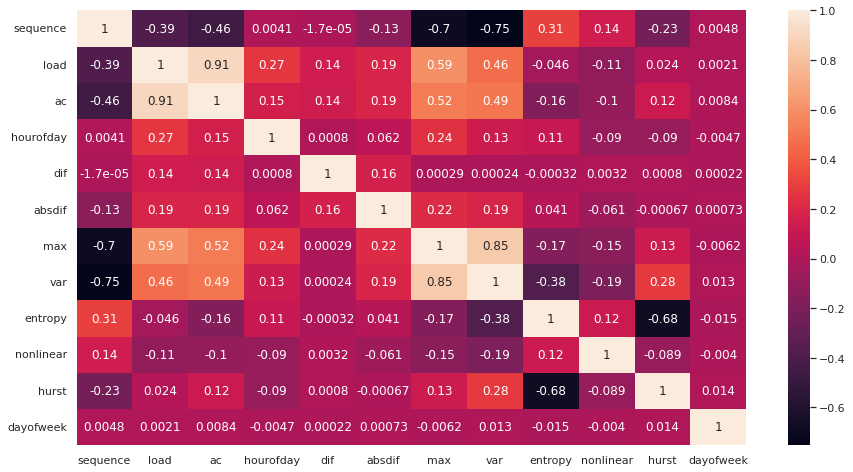

In [8]:
print("Variable Correlation Matrix")
corr_X = train_df.corr()
sn.set(rc = {'figure.figsize':(15,8)})
sn.heatmap(corr_X, annot=True)
plt.show()

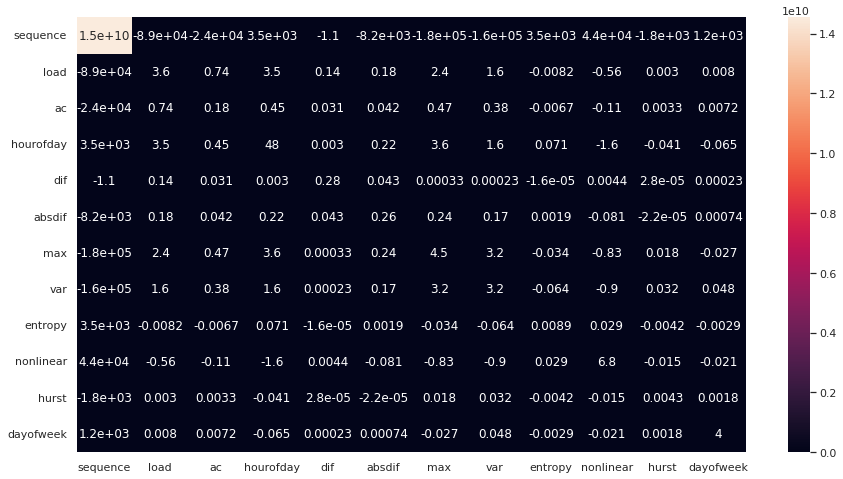

In [9]:
cov_X = train_df.cov()
sn.set(rc = {'figure.figsize':(15,8)})
sn.heatmap(cov_X, annot=True)
plt.show()

In [10]:
sn.pairplot(train_df[train_df.columns], size=2.0)


/opt/app-root/lib64/python3.8/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Error in callback <function flush_figures at 0x7fb6f68f15e0> (for post_execute):


KeyboardInterrupt: 

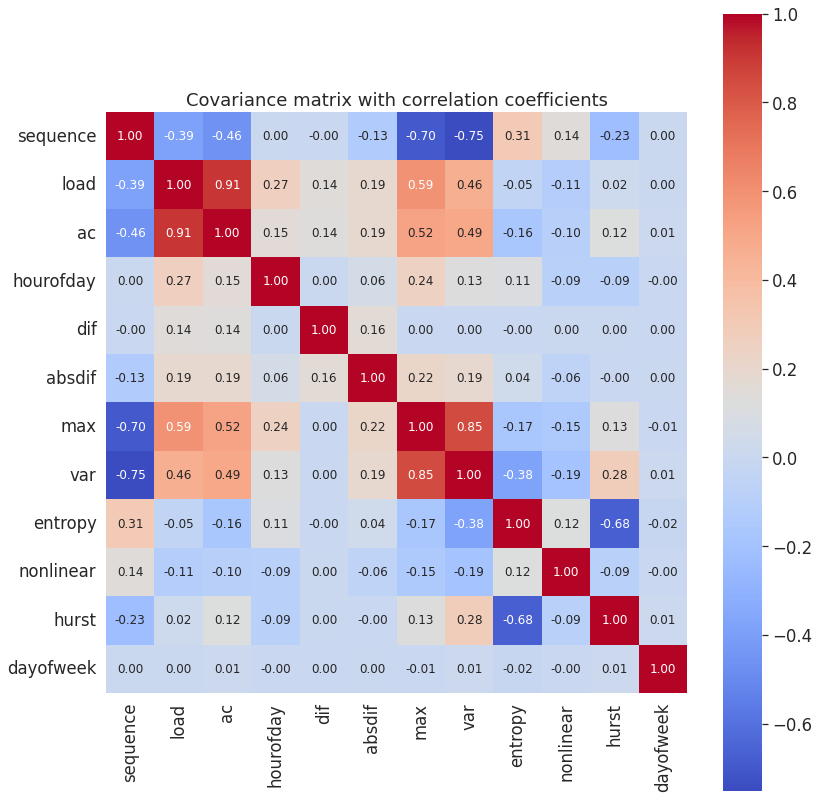

In [34]:
# Code snippet coutesy of: https://benjaminobi.medium.com/5-minutes-tutorial-on-how-to-compute-and-visualize-the-covariance-matrix-2597ab98d9ee#:~:text=The%20covariance%20matrix%20gives%20the,that%20displays%20the%20correlation%20coefficients.
#
stdsc = StandardScaler() 
X_std = stdsc.fit_transform(df[train_df.columns].iloc[:,range(0,12)].values)
cov_mat =np.cov(X_std.T)
plt.figure(figsize=(12,12))
sn.set(font_scale=1.5)
hm = sn.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 cmap='coolwarm',                 
                 yticklabels=train_df.columns,
                 xticklabels=train_df.columns)
plt.title('Covariance matrix with correlation coefficients', size = 18)
plt.tight_layout()
plt.show()

In [79]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif

def plotFeaturePerformance( fs, ticks, title ):
    # what are scores for the features
    for i in range(len(fs.scores_)):
        print('Feature %d: %f' % (i, fs.scores_[i]))
        
    # plot the scores
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.xlabel("Feature")
    plt.ylabel("K-Best Score")
    plt.title(label=title, loc="center")
    plt.xticks(np.arange(len(ticks)), labels=ticks, rotation=70)
    
    plt.show()

def selectFeatures( X_train, y_pred, criteria, num_features ):
    fs = SelectKBest(criteria, k=num_features)
    fs.fit(X_train,y_pred)
    new_x_train = fs.transform(X_train)
    
    return new_x_train, fs

In [80]:
# Define the number of features to find.
num_features = 5
print("Column names:\n{}".format(train_X.columns))
new_x_train1, fs1 = selectFeatures( train_X, train_y, f_classif, num_features )
new_x_train2, fs2 = selectFeatures( train_X, train_y, f_regression, num_features )

Column names:
Index(['sequence', 'load', 'hourofday', 'dif', 'absdif', 'max', 'var',
       'entropy', 'nonlinear', 'hurst', 'dayofweek'],
      dtype='object')


Feature 0: 113387.838950
Feature 1: 1965360.570073
Feature 2: 9794.751825
Feature 3: 7858.763535
Feature 4: 15936.573793
Feature 5: 153445.765468
Feature 6: 134719.813549
Feature 7: 11663.758853
Feature 8: 4233.177434
Feature 9: 5883.074959
Feature 10: 29.446552


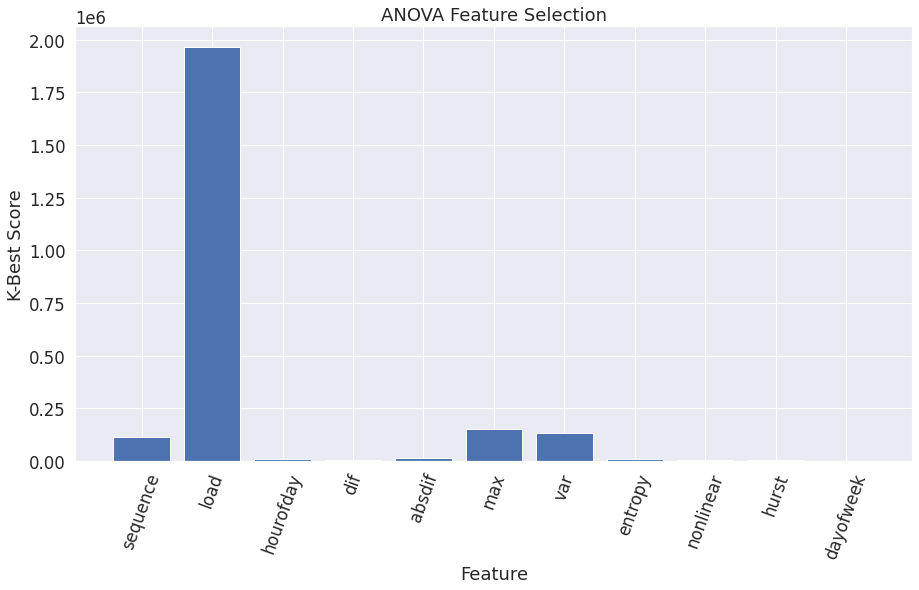

In [82]:
# Plot the feature selection charts.
plotFeaturePerformance( fs1, train_X.columns, "ANOVA Feature Selection" )
plotFeaturePerformance( fs2, train_X.columns, "Regression Feature Selection" )

In [14]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
Xnorm = scale(train_X)

# Perform the Principal Component Analysis. The number of components is the number of coumns in the dataset.
# The number of components is the minimum of the number of data elements and festures 
n_components=min(train_X.shape[0], train_X.shape[1])
print("Number of comoponets: {}".format(n_components))
pca = PCA(n_components)
Xnew = pca.fit_transform(Xnorm)
print("PCA details => {}".format(pca))

print(pca.get_params())

print('='*50)
print("Explained Variance:")
# Calculate the amount of variance explained by each PC
var= pca.explained_variance_ratio_
print(var)

print('='*50)
print("Cumulative Explained Variance:")

#cum_var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
cum_var=np.cumsum(pca.explained_variance_ratio_*100)
print(cum_var)

dimensions = {}

# Find the minimum dimensions that capture 85% and 95% respectively
num_dimensions = 0
for value in cum_var:
    if value >= 85:
        dimensions[value]=num_dimensions
        break
    num_dimensions += 1

num_dimensions = 0
for value in cum_var:
    if value >= 95:
        dimensions[value]=num_dimensions
        break
    num_dimensions += 1

print('='*50)

Number of comoponets: 11
PCA details => PCA(n_components=11)
{'copy': True, 'iterated_power': 'auto', 'n_components': 11, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}
Explained Variance:
[0.29673715 0.15425831 0.10136684 0.09121094 0.09012841 0.08089791
 0.07294822 0.04842635 0.0290573  0.0249145  0.01005407]
Cumulative Explained Variance:
[ 29.67371513  45.09954607  55.23623054  64.35732446  73.37016542
  81.45995668  88.75477905  93.5974138   96.50314332  98.9945929
 100.        ]


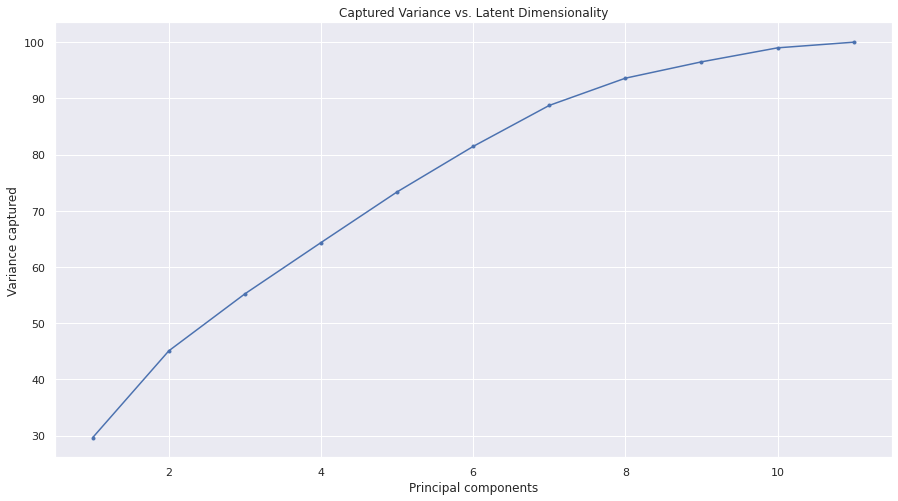

The minimum dimension that captures at least 89% variance is: 6
The minimum dimension that captures at least 97% variance is: 8


In [15]:
pca_num = a_list = list(range(1, n_components+1))
plt.plot(pca_num, cum_var, marker='.')
plt.xlabel("Principal components")
plt.ylabel("Variance captured")
plt.title(label="Captured Variance vs. Latent Dimensionality", loc="center")
plt.show()

for key,value in dimensions.items():
    print("The minimum dimension that captures at least {:.0f}% variance is: {}".format(key,value))

In [16]:
print(pca.components_)

[[-4.54963949e-01  3.52251748e-01  1.10835672e-01  3.24987376e-02
   1.50839952e-01  4.89800984e-01  5.07587627e-01 -2.55056877e-01
  -1.51085428e-01  2.17680369e-01  4.16434152e-03]
 [ 3.11238184e-02  3.16571309e-01  3.71425795e-01  1.16885130e-01
   2.34244968e-01  1.94162813e-01  6.93267053e-05  5.73375241e-01
   1.55866200e-02 -5.70002237e-01 -2.68345326e-02]
 [ 8.93789369e-02  5.78086627e-02 -1.96617492e-01  7.88298969e-01
   5.18661364e-01 -1.27086158e-01 -9.17946249e-02 -9.49203239e-02
   5.79563898e-02  1.44485999e-01  4.20010936e-02]
 [-1.58722853e-01 -2.27506222e-02 -3.00837400e-01 -1.15388113e-02
   1.43405517e-02  7.48094459e-02  6.02387058e-02  6.00762155e-02
   4.25343554e-01 -7.73269870e-02 -8.26871586e-01]
 [-2.09948047e-01 -8.48143267e-03 -4.01247348e-01 -8.14759788e-02
   9.18873965e-04  1.13669361e-01  1.09267168e-01  1.16682505e-01
   6.44328962e-01 -1.46582716e-01  5.59544565e-01]
 [ 1.60325194e-01  2.15310361e-01  5.76206458e-01  2.45075331e-01
  -3.75232499e-01 -

In [17]:
train_X

,sequence,load,hourofday,dif,absdif,max,var,entropy,nonlinear,hurst,dayofweek
0,105541,2.245,0,0.987,0.987,6.215,3.074549,0.678886,0.052903,0.994071,0
1,105542,2.259,0,0.014,0.014,6.215,3.172867,0.667450,0.054829,0.994154,0
2,105543,2.269,0,0.010,0.010,6.215,3.270112,0.647777,0.056991,0.994220,0
3,105544,2.268,0,-0.001,0.001,6.215,3.303763,0.629227,0.057606,0.994150,0
4,105545,2.270,0,0.002,0.002,6.215,3.302744,0.621295,0.082640,0.994041,0
...,...,...,...,...,...,...,...,...,...,...,...
417715,523256,2.543,21,-0.003,0.003,0.000,0.000000,0.000000,0.000000,0.000000,2
417716,523257,2.417,21,-0.126,0.126,0.000,0.000000,0.000000,0.000000,0.000000,2
417717,523258,0.999,21,-1.418,1.418,0.000,0.000000,0.000000,0.000000,0.000000,2
417718,523259,0.966,21,-0.033,0.033,0.000,0.000000,0.000000,0.000000,0.000000,2


In [18]:
pd.DataFrame(Xnorm)

,0,1,2,3,4,5,6,7,8,9,10
0,-1.732047,0.031914,-1.659524,1.859011,1.633999,1.050126,0.673127,-0.306037,-0.542338,0.325913,-1.488808
1,-1.732038,0.039319,-1.659524,0.026370,-0.287489,1.050126,0.728126,-0.427219,-0.541600,0.327174,-1.488808
2,-1.732030,0.044609,-1.659524,0.018836,-0.295388,1.050126,0.782525,-0.635696,-0.540772,0.328183,-1.488808
3,-1.732022,0.044080,-1.659524,-0.001882,-0.313161,1.050126,0.801349,-0.832269,-0.540536,0.327108,-1.488808
4,-1.732013,0.045138,-1.659524,0.003768,-0.311186,1.050126,0.800779,-0.916324,-0.530947,0.325441,-1.488808
...,...,...,...,...,...,...,...,...,...,...,...
417715,1.732013,0.189539,1.375005,-0.005649,-0.309212,-1.866220,-1.046775,-7.500160,-0.562601,-14.864864,-0.485558
417716,1.732022,0.122892,1.375005,-0.237319,-0.066310,-1.866220,-1.046775,-7.500160,-0.562601,-14.864864,-0.485558
417717,1.732030,-0.627149,1.375005,-2.670795,2.485141,-1.866220,-1.046775,-7.500160,-0.562601,-14.864864,-0.485558
417718,1.732038,-0.644604,1.375005,-0.062154,-0.249967,-1.866220,-1.046775,-7.500160,-0.562601,-14.864864,-0.485558


In [19]:
pd.DataFrame(Xnew)

,0,1,2,3,4,5,6,7,8,9,10
0,2.002978,-0.185953,2.273206,1.851311,-0.193777,-1.577760,-0.592022,-0.514548,-0.247288,-0.292278,-0.466149
1,1.715176,-0.918102,-0.160956,1.840982,-0.054131,-1.284614,-1.063877,-0.078405,-0.230866,-0.239165,-0.411986
2,1.796479,-1.039252,-0.155697,1.831860,-0.071567,-1.246564,-1.048937,-0.078683,-0.078883,-0.229560,-0.409501
3,1.852357,-1.158097,-0.164488,1.821363,-0.090463,-1.210130,-1.034047,-0.072952,0.062272,-0.232781,-0.430330
4,1.872545,-1.203734,-0.150602,1.820424,-0.094379,-1.188828,-1.025435,-0.071483,0.123281,-0.237810,-0.445173
...,...,...,...,...,...,...,...,...,...,...,...
417715,-3.300913,4.365968,-1.425005,-0.038843,-0.573688,-1.043688,-2.212715,-1.312352,15.637103,-1.281116,-1.087478
417716,-3.295283,4.374689,-1.485499,-0.031171,-0.554026,-1.205957,-1.919457,-1.307645,15.655169,-1.295458,-1.091425
417717,-3.253715,4.450475,-2.123824,0.050560,-0.347052,-2.921220,1.167620,-1.299099,15.841801,-1.438729,-1.138513
417718,-3.587653,4.109176,-1.487039,-0.018368,-0.561960,-1.259362,-2.031624,-1.980056,15.590240,-1.163018,-1.180481
